somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -t b1813 ip_diffim
#setup -k -r .
setup -t 1813 -r .
scons
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [2]:
import sys
from collections import namedtuple

import numpy as np
import pandas as pd

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

In [3]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

In [8]:
import lmfit

def fitDipole(w=100, h=100, xc=50., yc=50., psfWidth=2., amplitude=2.2, noise=0.2, verbose=False, plot=False):

#     psfWidth = 2.0
#     w, h = 100, 100
#     xc, yc = 50., 50.
#     ht = 2.2

    y, x = np.mgrid[:w, :h]
    x = x.flatten()
    y = y.flatten()
    in_x = [x, y]

    ## Note right now we are only fitting one amplitude and the 4 positions, not
    ##   anything related to the shape of the PSF!
    def dipoleFunc(x, amp, xcenPos, ycenPos, xcenNeg, ycenNeg): #, sig1, sig2):
        """
        Dipole based on 2-d double-gaussian: 
        dipoleFunc(x, amp, xcenPos, ycenPos, xcenNeg, ycenNeg) #, sig1, sig2)
        """
        #return (amp/(sqrt(2*pi)*wid)) * exp(-(x-cen)**2 /(2*wid**2))
        generator = afwMath.DoubleGaussianFunction2D(psfWidth, psfWidth*1.75, 0.1)
        zout = np.array([generator(x[0][i] - xcenPos, x[1][i] - ycenPos) for i in np.arange(len(x[0]))])
        zout -= np.array([generator(x[0][i] - xcenNeg, x[1][i] - ycenNeg) for i in np.arange(len(x[0]))])
        zout *= amp / zout.max()
        return zout

    #z = np.array([generator(in_x[0][i] - xc, in_x[1][i] - yc) for i in np.arange(len(in_x[0]))])
    #z *= ht / z.max()
    z = dipoleFunc(in_x, ht, xc+2., yc+2., xc-2., yc-2.) #, psfWidth, psfWidth*1.75)
    z += np.random.normal(0., 0.2, x.shape) #* (0.1 + np.sqrt(np.abs(z)))
    #plt.imshow(z.reshape(w, h), origin='lower', interpolation='none', cmap='gray', vmin=-ht, vmax=ht)

    gmod = lmfit.Model(dipoleFunc)
    #%timeit -r1 gmod.fit(z, x=in_x, amp=1., xcenPos=53.1, ycenPos=52.8, xcenNeg=47.2, ycenNeg=47.5, verbose=False)
    result = gmod.fit(z, x=in_x, amp=1., xcenPos=53.1, ycenPos=52.8, xcenNeg=47.2, ycenNeg=47.5) #, sig1=1., sig2=2.)

    if verbose: print(result.fit_report())

    if plot:
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        plt.imshow(z.reshape(w, h), origin='lower', interpolation='none', cmap='gray', vmin=-ht, vmax=ht)
        plt.title("Data")
        plt.subplot(1, 3, 2)
        plt.imshow(result.best_fit.reshape(w, h), origin='lower', interpolation='none', cmap='gray', vmin=-ht, vmax=ht)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        plt.imshow(z.reshape(w, h) - result.best_fit.reshape(w, h), origin='lower', cmap='gray', interpolation='none')
        plt.title("Residual")
        
    return x, y, z, result

 - Adding parameter "amp"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
[[Model]]
    Model(dipoleFunc)
[[Fit Statistics]]
    # function evals   = 33
    # data points      = 10000
    # variables        = 5
    chi-square         = 405.539
    reduced chi-square = 0.041
[[Variables]]
    amp:       2.19647308 +/- 0.043944 (2.00%) (init= 1)
    xcenPos:   52.0296604 +/- 0.079155 (0.15%) (init= 53.1)
    ycenPos:   51.9868040 +/- 0.078913 (0.15%) (init= 52.8)
    xcenNeg:   47.9875040 +/- 0.079155 (0.16%) (init= 47.2)
    ycenNeg:   48.0247483 +/- 0.078913 (0.16%) (init= 47.5)
[[Correlations]] (unreported correlations are <  0.100)
    C(ycenPos, xcenNeg)          = -0.354 
    C(xcenPos, ycenNeg)          = -0.354 
    C(amp, xcenPos)              = -0.282 
    C(amp, ycenPos)              = -0.243 
    C(xcenPos, xcenNeg)          = -0.218 
    C(ycenPos, ycenNeg)          = -0.205 
    C(amp, ycenNeg)         

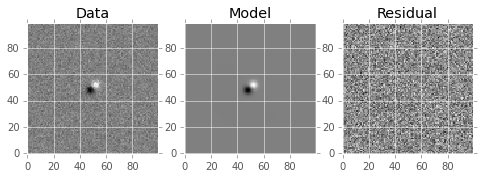

In [10]:
x, y, z, result = fitDipole(w=100, h=100, xc=50., yc=50., psfWidth=2., amplitude=2.2, noise=0.2, verbose=True, plot=True)